# pred penyakit paru vit

In [80]:
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from transformers import ViTForImageClassification, ViTFeatureExtractor, ViTConfig
from torchvision import transforms
import os

#optional
import matplotlib.pyplot as plt

## LOAD DATASET

In [81]:
# Load train and validation data
train_df = pd.read_csv('datasets/CheXpert-v1.0-small/train.csv')
valid_df = pd.read_csv('datasets/CheXpert-v1.0-small/valid.csv')

if 'train_df' in locals() and 'valid_df' in locals():
    print("dataset loaded")
else:
    print("fail load dataset")

dataset loaded


In [82]:
# Display first 5 rows of validation data
train_df.tail()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
223409,CheXpert-v1.0-small/train/patient64537/study2/...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,-1.0,0.0,1.0,NaN,NaN,NaN
223410,CheXpert-v1.0-small/train/patient64537/study1/...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,0.0,-1.0,NaN,-1.0,NaN,NaN,NaN
223411,CheXpert-v1.0-small/train/patient64538/study1/...,Female,0,Frontal,AP,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223412,CheXpert-v1.0-small/train/patient64539/study1/...,Female,0,Frontal,AP,NaN,NaN,1.0,1.0,NaN,NaN,NaN,-1.0,1.0,0.0,NaN,NaN,NaN,0.0
223413,CheXpert-v1.0-small/train/patient64540/study1/...,Female,0,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [83]:
# Cetak jumlah data unik pada setiap kolom di train_df (kecuali 'Path')
print("Jumlah data unik pada setiap kolom di train_df (kecuali 'Path'):")
unique_counts = train_df.loc[:, ~train_df.columns.isin(['Path'])].nunique()
unique_values = train_df.loc[:, ~train_df.columns.isin(['Path'])].apply(lambda x: [str(val) for val in x.unique()])
result = pd.DataFrame({'Unique Count': unique_counts, 'Unique Values': unique_values.apply(lambda x: ', '.join(x))})
print(result)


Jumlah data unik pada setiap kolom di train_df (kecuali 'Path'):
                            Unique Count  \
Sex                                    3   
Age                                   74   
Frontal/Lateral                        2   
AP/PA                                  4   
No Finding                             1   
Enlarged Cardiomediastinum             3   
Cardiomegaly                           3   
Lung Opacity                           3   
Lung Lesion                            3   
Edema                                  3   
Consolidation                          3   
Pneumonia                              3   
Atelectasis                            3   
Pneumothorax                           3   
Pleural Effusion                       3   
Pleural Other                          3   
Fracture                               3   
Support Devices                        3   

                                                                Unique Values  
Sex               

### note
nan itu g ada<br>
1.0 itu ya<br>
**nahh un curtain ini apa ngentod?**

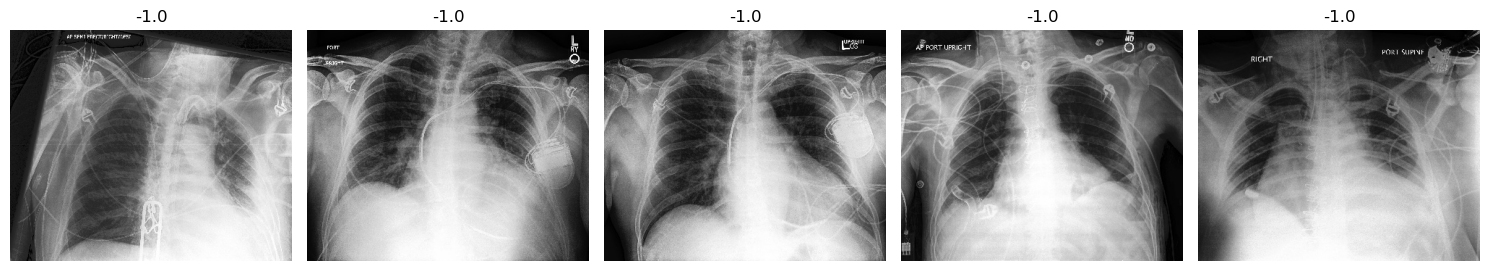

In [84]:
# Ambil 5 baris dari train_df yang label 'Support Devices' bernilai -1.0
support_device_neg1 = train_df[train_df['Support Devices'] == -1.0].head(5)

plt.figure(figsize=(15, 3))
for i, (_, row) in enumerate(support_device_neg1.iterrows()):
    img_path = 'datasets/' + row['Path']
    image = Image.open(img_path).convert('RGB')
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{row['Support Devices']}")
plt.tight_layout()
plt.show()

>Dari hasil penelitian diatas bahwa uncurtain (-1.0) pada `'Support Devices'` cenderung positive (1.0). peneliti melabeli uncertain karena bahwa kondisi yang ada digambar tidak tampak terlihat jelas

In [85]:
# Hitung jumlah baris setelah drop semua data yang memiliki nilai -1.0 pada kolom label
label_cols = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

mask = ~(train_df[label_cols] == -1.0).any(axis=1)
jumlah_data_tanpa_minus1 = mask.sum()
print(f"Jumlah data train setelah drop baris dengan -1.0 di kolom label: {jumlah_data_tanpa_minus1}")

mask = ~(valid_df[label_cols] == -1.0).any(axis=1)
jumlah_data_tanpa_minus1 = mask.sum()
print(f"Jumlah data valid setelah drop baris dengan -1.0 di kolom label: {jumlah_data_tanpa_minus1}")

Jumlah data train setelah drop baris dengan -1.0 di kolom label: 138358
Jumlah data valid setelah drop baris dengan -1.0 di kolom label: 234


>Dari hasil penelitian saya jika saya menghilangkan kolom yang memiliki nilai uncertain (-1.0) saya masih memiliki cukup data yang konsisten untuk training

## PRE PROSESING

### Hapus data yang tidak diperlukam

In [86]:
# Hapus kolom yang tidak diperlukan
columns_to_drop = ['Sex', 
                   'Age', 
                   'Frontal/Lateral', 
                   'AP/PA',
                #    'No Finding'
                   ]
train_df = train_df.drop(columns=columns_to_drop)
valid_df = valid_df.drop(columns=columns_to_drop)

print(f"Kolom {columns_to_drop} yang tidak diperlukan telah dihapus.")

Kolom ['Sex', 'Age', 'Frontal/Lateral', 'AP/PA'] yang tidak diperlukan telah dihapus.


In [87]:
# Drop baris pada train_df dan valid_df yang memiliki nilai -1.0 pada kolom label
train_df = train_df[~(train_df[label_cols] == -1.0).any(axis=1)].reset_index(drop=True)
valid_df = valid_df[~(valid_df[label_cols] == -1.0).any(axis=1)].reset_index(drop=True)

print(f"train_df shape setelah drop: {train_df.shape}")
print(f"valid_df shape setelah drop: {valid_df.shape}")

train_df shape setelah drop: (138358, 15)
valid_df shape setelah drop: (234, 15)


In [ ]:
# Membuat dataset baru untuk train_df: path -> [label1, label2, ...] hanya untuk label dengan nilai 1.0
label_columns = train_df.columns[1:]  # kolom label (kecuali 'Path')
train_df2 = []
for idx, row in train_df.iterrows():
    labels = [col for col in label_columns if row[col] == 1.0]
    train_df2.append({'Path': row['Path'], 'Labels': labels})

# Membuat dataset baru untuk valid_df
valid_df2 = []
for idx, row in valid_df.iterrows():
    labels = [col for col in label_columns if row[col] == 1.0]
    valid_df2.append({'Path': row['Path'], 'Labels': labels})

# Contoh hasil
print("Contoh train_df:")
for item in train_df2[:5]:
    print(f"{item['Path']} : {item['Labels']}")

print("\nContoh valid_df:")
for item in valid_df2[:5]:
    print(f"{item['Path']} : {item['Labels']}")

del train_df
del valid_df
# print("train_df dan valid_df telah dihapus dari memory.")

Contoh train_df:
CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg : ['No Finding', 'Support Devices']
CheXpert-v1.0-small/train/patient00003/study1/view1_frontal.jpg : ['Edema']
CheXpert-v1.0-small/train/patient00004/study1/view1_frontal.jpg : ['No Finding']
CheXpert-v1.0-small/train/patient00004/study1/view2_lateral.jpg : ['No Finding']
CheXpert-v1.0-small/train/patient00005/study1/view1_frontal.jpg : ['No Finding', 'Support Devices']

Contoh valid_df:
CheXpert-v1.0-small/valid/patient64541/study1/view1_frontal.jpg : ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity']
CheXpert-v1.0-small/valid/patient64542/study1/view1_frontal.jpg : ['Support Devices']
CheXpert-v1.0-small/valid/patient64542/study1/view2_lateral.jpg : ['Support Devices']
CheXpert-v1.0-small/valid/patient64543/study1/view1_frontal.jpg : ['Enlarged Cardiomediastinum', 'Lung Opacity', 'Edema']
CheXpert-v1.0-small/valid/patient64544/study1/view1_frontal.jpg : ['No Finding']


In [103]:
# Hapus data yang tidak memiliki label (baris dengan 'Labels' kosong) dari train_df2 dan valid_df2
train_df2 = [item for item in train_df2 if item['Labels']]
valid_df2 = [item for item in valid_df2 if item['Labels']]

print(f"Jumlah data train setelah drop no label: {len(train_df2)}")
print(f"Jumlah data valid setelah drop no label: {len(valid_df2)}")

Jumlah data train setelah drop no label: 134102
Jumlah data valid setelah drop no label: 225


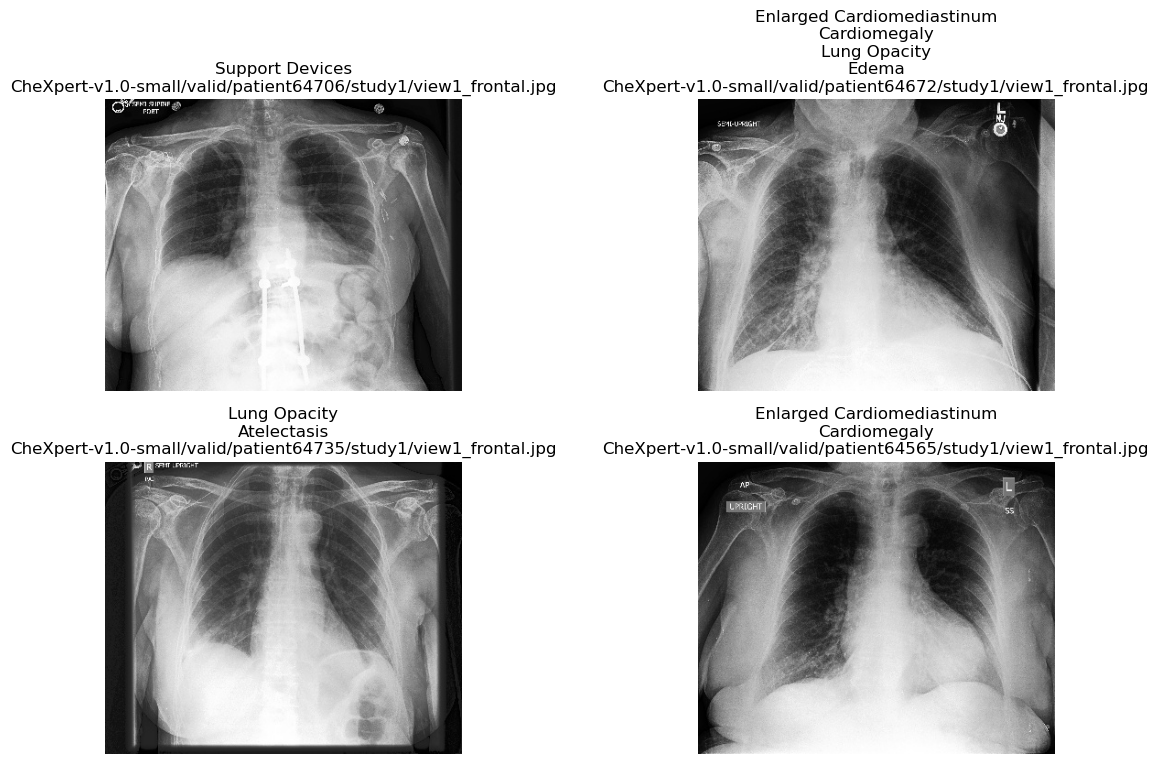

In [108]:
import random
from PIL import Image

import matplotlib.pyplot as plt

# Pilih sampel acak dari valid_df2
samples = random.sample(valid_df2, 4)

plt.figure(figsize=(12, 15))
for i, sample in enumerate(samples):
    img_path = 'datasets/' + sample['Path']
    image = Image.open(img_path).convert('RGB')
    plt.subplot(4, 2, i+1)
    plt.imshow(image)
    plt.axis('off')
    title = ('\n'.join(sample['Labels']) if sample['Labels'] else 'No Label') + f"\n{sample['Path']}"
    plt.title(title)
plt.tight_layout()
plt.show()

## MENYIAPKAN DATASET

### Membuat Data Test dari Data Valid

In [110]:
# Bagi valid_df menjadi validasi dan test set
valid_df2, test_df2 = train_test_split(valid_df2, test_size=0.2, random_state=42)
print("valid_df menjadi validasi dan test set")

valid_df menjadi validasi dan test set


In [111]:
print(f"Jumlah data train: {len(train_df2)}")
print(f"Jumlah data validasi: {len(valid_df2)}")
print(f"Jumlah data test: {len(test_df2)}\n")

Jumlah data train: 134102
Jumlah data validasi: 180
Jumlah data test: 45



# TRAIN

In [30]:
# from transformers import AutoImageProcessor

# processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')
# processor

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [112]:
from transformers import ViTForImageClassification, ViTConfig

# Konfigurasi model Vision Transformer
config = ViTConfig(
    image_size=224,  # Ukuran input gambar (224x224)
    num_labels=14,   # Jumlah label output (disesuaikan dengan dataset)
    hidden_size=768, # Ukuran dimensi hidden layer
    num_hidden_layers=12, # Jumlah layer transformer
    num_attention_heads=12, # Jumlah head pada multi-head attention
    intermediate_size=3072, # Ukuran layer intermediate
    patch_size=16,    # Ukuran patch gambar
    hidden_dropout_prob=0.1, # Dropout pada hidden layer
    attention_probs_dropout_prob=0.1, # Dropout pada attention
)

# Membuat model Vision Transformer
model = ViTForImageClassification(config)

# Menampilkan arsitektur model
print(model)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [113]:
from transformers import ViTFeatureExtractor

# Load pre-trained ViT model and feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('WinKawaks/vit-small-patch16-224')
model = ViTForImageClassification.from_pretrained(
    'WinKawaks/vit-small-patch16-224',
    num_labels=14,
    ignore_mismatched_sizes=True
)

print("Pre-trained ViT model dan feature extractor telah dimuat.")

/opt/conda/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([14]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([14, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pre-trained ViT model dan feature extractor telah dimuat.


In [136]:
# Definisikan transformasi gambar
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Ubah ukuran gambar menjadi 224x224
    transforms.ToTensor(),          # Konversi gambar menjadi tensor
    transforms.Normalize(           # Normalisasi gambar dengan mean dan std
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )
])

print("Transformasi gambar telah ditambahkan.")

Transformasi gambar telah ditambahkan.


In [138]:
# Definisikan transformasi gambar dengan menjaga aspect ratio
image_transforms = transforms.Compose([
    transforms.Resize(224),                # Resize sisi terpendek ke 224, aspect ratio terjaga
    transforms.CenterCrop(224),            # Crop tengah menjadi 224x224
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("Transformasi gambar dengan aspect ratio telah ditambahkan.")

Transformasi gambar dengan aspect ratio telah ditambahkan.


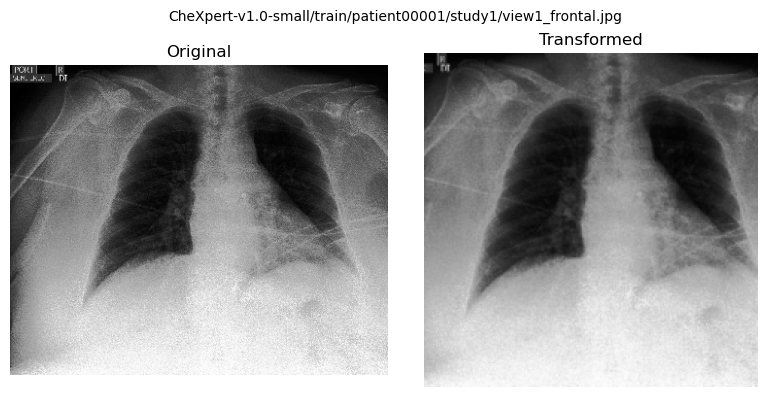

In [139]:
import matplotlib.pyplot as plt

# Pilih satu sampel dari train_df2
sample = train_df2[0]
img_path = 'datasets/' + sample['Path']
image = Image.open(img_path).convert('RGB')
transformed_image = image_transforms(image)

# Konversi tensor ke numpy untuk ditampilkan
img_np = transformed_image.permute(1, 2, 0).cpu().numpy()
# Undo normalization for visualization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img_np = img_np * std + mean
img_np = img_np.clip(0, 1)

plt.figure(figsize=(8, 4))
# Gambar asli
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')
plt.title('Original')

# Gambar hasil transform
plt.subplot(1, 2, 2)
plt.imshow(img_np)
plt.axis('off')
plt.title('Transformed')

plt.suptitle(sample['Path'], fontsize=10)
plt.tight_layout()
plt.show()

In [34]:
class CheXpertDataset(Dataset):
     def __init__(self, data_list, label_columns, transform):
          self.data_list = data_list
          self.label_columns = list(label_columns)
          self.transform = transform

     def __len__(self):
          return len(self.data_list)

     def __getitem__(self, idx):
          item = self.data_list[idx]
          img_path = 'datasets/' + item['Path']
          image = Image.open(img_path).convert('RGB')
          image = self.transform(image)
          # Multi-hot encoding
          labels = np.zeros(len(self.label_columns), dtype=np.float32)
          for label in item['Labels']:
               if label in self.label_columns:
                    labels[self.label_columns.index(label)] = 1.0
          labels = torch.tensor(labels)
          return image, labels

# DataLoader
train_dataset = CheXpertDataset(train_df2, label_columns, image_transforms)
valid_dataset = CheXpertDataset(valid_df2, label_columns, image_transforms)
# Optimal DataLoader configuration for GPU performance
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=2)

In [35]:
# Optimizer & Loss
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
# Asymmetric Loss implementation
class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8):
        super(AsymmetricLoss, self).__init__()
        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.eps = eps

    def forward(self, logits, targets):
        x_sigmoid = torch.sigmoid(logits)
        xs_pos = x_sigmoid
        xs_neg = 1 - x_sigmoid

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1)

        # Basic CE calculation
        loss_pos = targets * torch.log(xs_pos.clamp(min=self.eps))
        loss_neg = (1 - targets) * torch.log(xs_neg.clamp(min=self.eps))
        loss = loss_pos + loss_neg

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            pt0 = xs_pos * targets
            pt1 = xs_neg * (1 - targets)
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * targets + self.gamma_neg * (1 - targets)
            loss *= (1 - pt) ** one_sided_gamma

        return -loss.mean()

criterion = AsymmetricLoss()

In [ ]:
import torch
from tqdm import tqdm
import numpy as np

# Fine-tuning pre-trained ViT model with enhancements
num_epochs = 50  # Increased for early stopping demonstration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define scheduler as None if not using a learning rate scheduler
scheduler = None

# Training parameters
patience = 3  # Untuk early stopping (berhenti jika tidak ada peningkatan dalam 3 epoch)
best_val_loss = np.inf
epochs_without_improvement = 0

# For tracking history
train_loss_history = []
val_loss_history = []
val_acc_history = []

# Mixed precision training
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Training loop with mixed precision
    train_loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
    for images, targets in train_loop:
        images = images.to(device, non_blocking=True)  # non_blocking for async transfer
        targets = targets.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)  # More efficient memory-wise
        
        # Mixed precision forward/backward
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            outputs = model(images).logits
            loss = criterion(outputs, targets)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        train_loop.set_postfix(loss=loss.item())
        
        # Memory cleanup (optional - see notes below)
        # if torch.cuda.is_available():
        #     torch.cuda.synchronize()  # Wait for all operations to complete

    epoch_loss = running_loss / len(train_loader.dataset)
    train_loss_history.append(epoch_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    val_loop = tqdm(valid_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
    with torch.no_grad():
        for images, targets in val_loop:
            images = images.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            
            outputs = model(images).logits
            loss = criterion(outputs, targets)
            val_loss += loss.item() * images.size(0)
            
            # _, predicted = torch.max(outputs.data, 1)
            # total += targets.size(0)
            # correct += (predicted == targets).sum().item()
            # Multi-label: pakai sigmoid + threshold

            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == targets).sum().item()
            total += targets.numel()  # total elemen label
            
            val_loop.set_postfix(val_loss=loss.item())

    val_loss /= len(valid_loader.dataset)
    val_accuracy = 100 * correct / total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_accuracy)
    
    print(f"\nEpoch {epoch+1}: Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs!")
            break

    # Learning rate scheduling (optional)
    if scheduler is not None:
        scheduler.step(val_loss)

# Load best model
model.load_state_dict(torch.load('best_model.pth'))
print("\nTraining complete!")
print(f"Best Validation Loss: {best_val_loss:.4f}")
print(f"Best Validation Accuracy: {max(val_acc_history):.2f}%")

/tmp/ipykernel_1872/3012083182.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
Epoch 1/10 [Train]:   0%|                                                                                                                                     | 0/27927 [00:00<?, ?it/s]/tmp/ipykernel_1872/3012083182.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
Epoch 1/10 [Val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 56.47it/s, val_loss=0.0637]



Epoch 1: Train Loss: 0.0504 | Val Loss: 0.0701 | Val Acc: 82.01%


Epoch 2/10 [Val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 56.91it/s, val_loss=0.0689]



Epoch 2: Train Loss: 0.0484 | Val Loss: 0.0720 | Val Acc: 81.40%


Epoch 3/10 [Val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 57.05it/s, val_loss=0.0747]



Epoch 3: Train Loss: 0.0461 | Val Loss: 0.0710 | Val Acc: 81.55%


Epoch 4/10 [Val]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 54.88it/s, val_loss=0.0754]



Epoch 4: Train Loss: 0.0430 | Val Loss: 0.0749 | Val Acc: 83.27%

Early stopping triggered after 4 epochs!

Training complete!
Best Validation Loss: 0.0701
Best Validation Accuracy: 83.27%


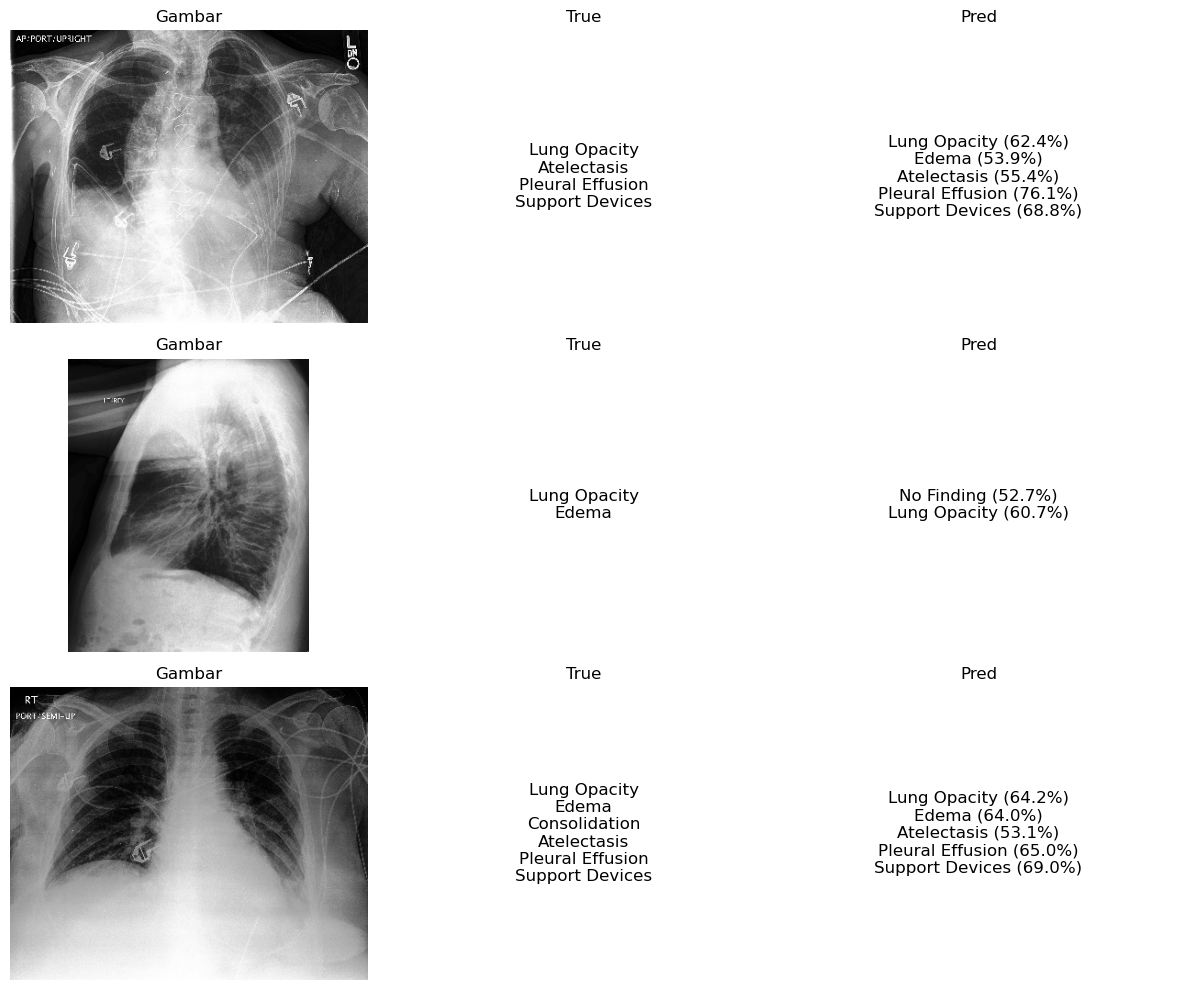

In [44]:
import random
import matplotlib.pyplot as plt

# Ambil 3 sampel acak dari test_df2
samples = random.sample(test_df2, 3)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))

for i, sample in enumerate(samples):
    img_path = 'datasets/' + sample['Path']
    image = Image.open(img_path).convert('RGB')
    input_tensor = image_transforms(image).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(input_tensor).logits
        probs = torch.sigmoid(logits).cpu().numpy()[0]
        pred = (probs > 0.5)
    pred_labels = [f"{label_columns[j]} ({probs[j]*100:.1f}%)" for j, v in enumerate(pred) if v]
    true_labels = sample['Labels']

    # Kolom 0: Gambar
    axes[i, 0].imshow(image)
    axes[i, 0].axis('off')
    axes[i, 0].set_title("Gambar")

    # Kolom 1: True label
    axes[i, 1].text(0.5, 0.5, '\n'.join(true_labels) if true_labels else 'No Label',
                    fontsize=12, ha='center', va='center')
    axes[i, 1].axis('off')
    axes[i, 1].set_title("True")

    # Kolom 2: Pred label + presentase
    axes[i, 2].text(0.5, 0.5, '\n'.join(pred_labels) if pred_labels else 'No Label',
                    fontsize=12, ha='center', va='center')
    axes[i, 2].axis('off')
    axes[i, 2].set_title("Pred")

plt.tight_layout()
plt.show()


In [48]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# Kumpulkan prediksi dan target dari seluruh test set
all_targets = []
all_preds = []

model.eval()
with torch.no_grad():
    for images, targets in test_loader:
        images = images.to(device)
        targets = targets.cpu().numpy()
        logits = model(images).logits
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > 0.5).astype(int)
        all_targets.append(targets)
        all_preds.append(preds)

all_targets = np.concatenate(all_targets, axis=0)
all_preds = np.concatenate(all_preds, axis=0)

# Multi-label metrics (average='macro' or 'micro')
f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)
accuracy = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
recall = recall_score(all_targets, all_preds, average='macro', zero_division=0)

print(f"F1 Score (macro): {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")

F1 Score (macro): 0.3862
Accuracy: 0.0213
Precision (macro): 0.4219
Recall (macro): 0.4595


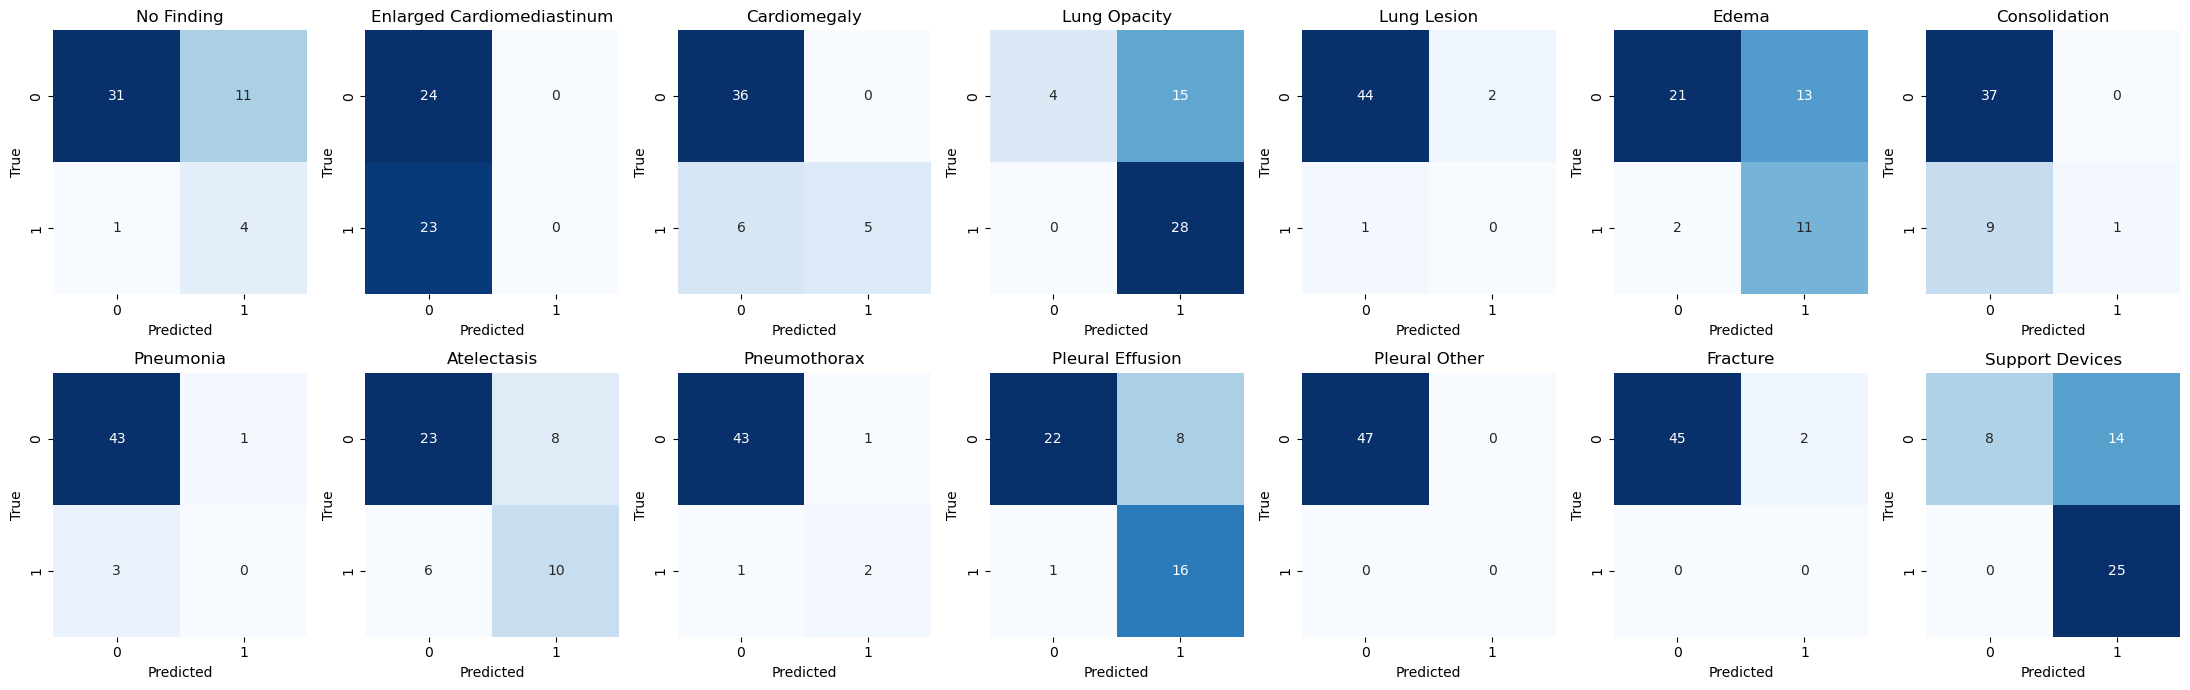

In [49]:
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

import matplotlib.pyplot as plt

# Hitung confusion matrix untuk setiap label
cm = multilabel_confusion_matrix(all_targets, all_preds)

fig, axes = plt.subplots(2, 7, figsize=(22, 7))
axes = axes.flatten()

for i, (ax, label) in enumerate(zip(axes, label_columns)):
    sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(label)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()